In [1]:
import numpy as np
import pandas as pd

from read import r_earth, default_and_smooth
import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '../data/2018/Erlangen/Rahsegel_Knoten.CSV'

In [3]:
df = pd.read_csv(filename, decimal=',', delimiter=';')
# Some column names start or end with white space. That's annoying, so remove that.
df.rename(columns=lambda x: x.strip(), inplace=True)

In [4]:
list(df.columns.values)

['Datum',
 'time',
 'Windspeed',
 'Windspeed kn',
 'Winddir',
 'GPSDIR',
 'GPSSPEED',
 'GPS in kn',
 'Logspeed',
 'SATLOCK',
 'latitude',
 'longitude',
 'YAW',
 'PITCH',
 'ROLL',
 'AWA',
 'AWD',
 'TWS',
 'TWD',
 'DFT',
 'SET',
 'TWSo',
 'TWSn']

Jetzt schaue ich mir mal an, was die einzelnen Spalten denn fur DAten enthalten udn wie die zusammengehoren, damit hc besser verstehe, was den hier so los ist.

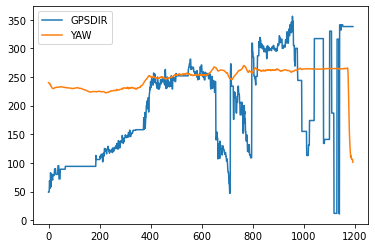

In [5]:
df.plot(y=['GPSDIR', 'YAW'])

Mmm, ich dachte, "YAW" ist die Richtung in die das Schiff fahrt? Die Fahrtstrecke ist doch eine grosser Halbkreis. Warum ist das "YAW" denn immer gleich?

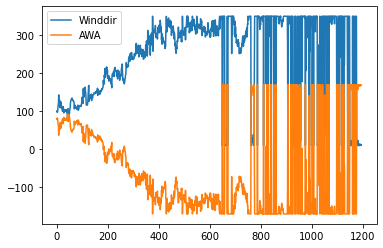

In [6]:
df.plot(y=['Winddir', 'AWA'])

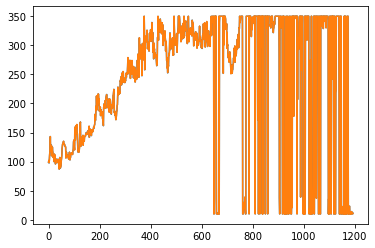

In [7]:
plt.plot(df['Winddir'])
plt.plot(180 - df['AWA'])

Man sieht am Plot: Winddir = 180 - AWA
Also ist AWA genau andersherum gemessen. Welche von dne beiden sollte ich denn nun benutzen?

Jetzt benenne ich die mal einige Spalten um, damit die Namen zu meinem Code passen (z.B. heisst bei mir die latitude LAT etc.).  Die WErte adnere ich hier nicht, nur die Namen.

In [8]:
df.rename(columns={'latitude':'LAT', 
                   'longitude':'LON', 
                   'Windspeed kn':'AWS', 
                   'Winddir':'TWA',  # not true, but as first step that's OK
                   'GPSDIR':'COG', 
                   'GPSSPEED':'SOG', 
                   'Logspeed': 'BSP', 
                   'YAW': 'HDC'}, inplace=True)

In [9]:
list(df.columns.values)

['Datum',
 'time',
 'Windspeed',
 'AWS',
 'TWA',
 'COG',
 'SOG',
 'GPS in kn',
 'BSP',
 'SATLOCK',
 'LAT',
 'LON',
 'HDC',
 'PITCH',
 'ROLL',
 'AWA',
 'AWD',
 'TWS',
 'TWD',
 'DFT',
 'SET',
 'TWSo',
 'TWSn']

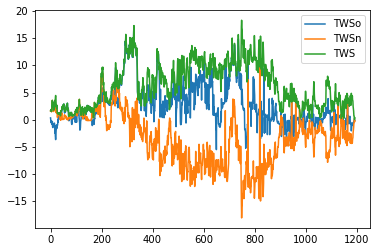

In [10]:
df.plot(y=['TWSo', 'TWSn', 'TWS'])


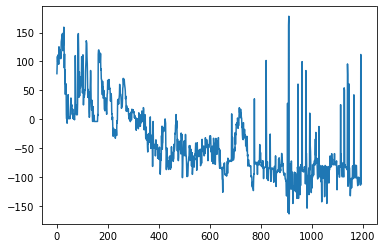

In [11]:
plt.plot(np.rad2deg(np.arctan2(df['TWSn'], df['TWSo'])))

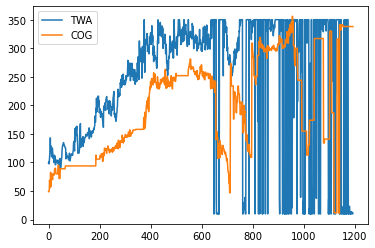

In [12]:
df.plot(y=['TWA', 'COG'])

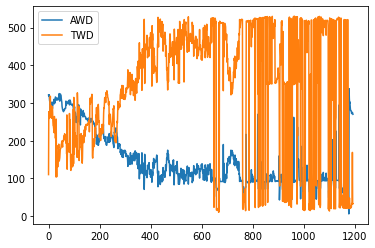

In [13]:
df.plot(y=['AWD', 'TWD'])

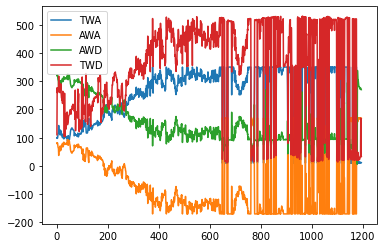

In [15]:
df.plot(y=['TWA', 'AWA', 'AWD', 'TWD'])

In [16]:
origin = None
if origin is None:
    origin = df['LAT'][0], df['LON'][0]
df.attrs['origin'] = origin
df.attrs['filename'] = filename
df['y'] = 2. * np.pi * r_earth / 360. * (df['LAT'] - origin[0])
df['x'] = 2. * np.pi * r_earth / 360. * \
              np.cos(np.deg2rad(df['LAT'])) * (df['LON'] - origin[1])


In [17]:
# There must be a better way than array concatenation, but this works and don't want
# to spend time to learn pandas better right now
arr = []
for d, t in zip(df['Datum'], df['time']):
    arr.append(pd.Timestamp(d + ' ' + t, tz='UTC'))
df['time'] = arr
df['time'] = df['time'].dt.tz_convert('Europe/Berlin')
df.set_index('time', inplace=True, drop=False)

In [18]:
# convert km/h to kn
for col in ['BSP']:
    df[col] = df[col] / 1.825
    
# The data is already filtered ot contain only sailing times
df['Segel'] = 1
df['Ruderschlaege/Minute'] = 0

In [19]:
default_and_smooth(df, halflife=10)

0.8386399700885274


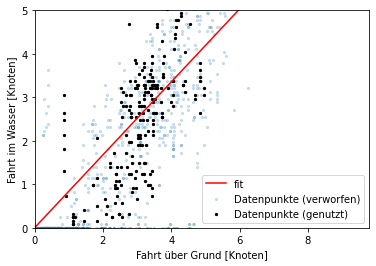

In [20]:
a, ind, ax = plot.fit_BSP(df)
ax.set_ylim(0, 5)
print(a)
fig = plt.gcf()

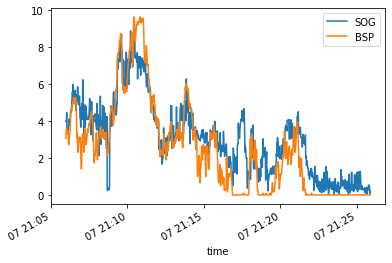

In [21]:
df.plot(y=['SOG', 'BSP'])

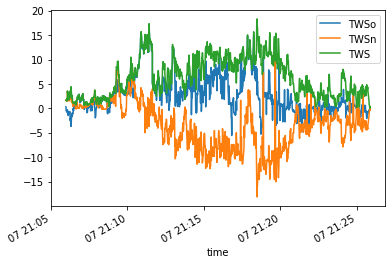

In [22]:
df.plot(y=['TWSo', 'TWSn', 'TWS'])

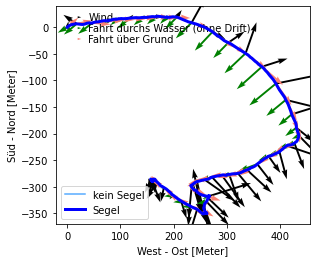

In [23]:
df['windang'] = np.rad2deg(np.arctan2(df['TWSo'], df['TWSn']))
plot.course(df, n=20,scale=20)

In [24]:
plot.folium_map(df)

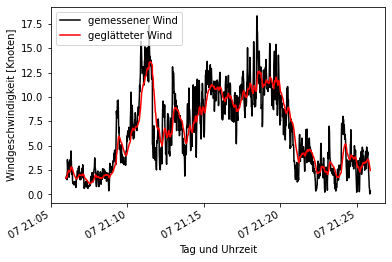

In [25]:
ax = df.plot(y=['TWS', 'TWS_s'], style=['k', 'r'])
ax.legend(['gemessener Wind', 'gegl\u00e4tteter Wind'])
ax.set_xlabel('Tag und Uhrzeit')
ax.set_ylabel('Windgeschwindigkeit [Knoten]')
fig = plt.gcf()


In [26]:
list(df.columns.values)

['Datum',
 'time',
 'Windspeed',
 'AWS',
 'TWA',
 'COG',
 'SOG',
 'GPS in kn',
 'BSP',
 'SATLOCK',
 'LAT',
 'LON',
 'HDC',
 'PITCH',
 'ROLL',
 'AWA',
 'AWD',
 'TWS',
 'TWD',
 'DFT',
 'SET',
 'TWSo',
 'TWSn',
 'y',
 'x',
 'Segel',
 'Ruderschlaege/Minute',
 'absTWA',
 'bearingdiff',
 'absbearingdiff',
 'TWA_drift',
 'absTWA_drift',
 'windang',
 'TWA_s',
 'TWS_s',
 'absTWA_s',
 'bearingdiff_s',
 'TWA_drift_s',
 'absTWA_drift_s',
 'Segel_s',
 'x_Segel_masked',
 'y_Segel_masked',
 'row_s']

In [37]:
def polar3(df, dfcorr=None, col='BSP'):
    fig, axes = plt.subplots(ncols=3, subplot_kw={'polar': True}, figsize = (13,7))
    ax1 = plot.polar(df.median()[col].unstack(), ax=axes[0],
                     labeltext='{:4.1f}-{:4.1f} kn')
    ax2 = plot.polar(df.mean()[col].unstack(), ax=axes[1],
                     labeltext='{:4.1f}-{:4.1f} kn')
    ax3 = plot.polar(np.log10(df.count()['BSP'].unstack()),
                     ax=axes[2], labeltext='{:4.1f}-{:4.1f} kn')
    if not dfcorr is None:
        ax1.set_prop_cycle(None)
        ax1 = plot.polar(dfcorr.median()[col].unstack(), ax=axes[0],
                         labeltext='__no_legend__', lw=3)
        ax2.set_prop_cycle(None)
        ax2 = plot.polar(dfcorr.mean()[col].unstack(), ax=axes[1],
                         labeltext='__no_legend__', lw=3)
        
    ax1.set_title('Polardiagram - Median')
    ax2.set_title('Polardiagram - Mean')
    ax3.set_title ('Log10(Anzahl Datenpunkte per bin)')
    ax1.legend(loc='upper left')

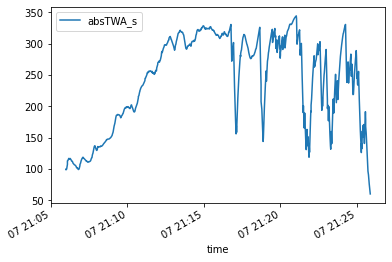

In [45]:
df.plot(y='absTWA_s')

(0.0, 4.0)

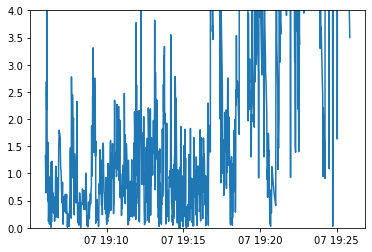

In [47]:
plt.plot(np.abs(df['absTWA_s'].diff()))
plt.ylim(0, 4)

In [40]:
speedbins=np.arange(1.5,16,3.)

mk_polar = plot.make_polar

kwdrift = {'speedbins': speedbins, 'anglecol': 'absTWA_s'}
prah, dprah = mk_polar(df, **kwdrift)
prahcorr, dprah = mk_polar(df.copy(), speedbins=speedbins, anglecol='windang')

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


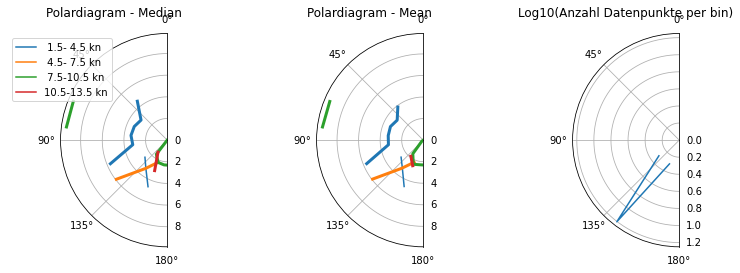

In [41]:
polar3(prah, prahcorr)